In [1]:
import pandas as pd
import base64
import io
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
clebs = pd.read_csv('images.tsv', delimiter="\t", engine='python', error_bad_lines=False)
print('Stats By Id')
clebs.groupby('Id').agg(['count']).describe()

Stats By Id


,Image
,count
count,27.000000
mean,111.259259
std,9.296784
min,86.000000
25%,106.500000
50%,114.000000
75%,116.500000
max,127.000000


In [13]:
def display_image(base64Image):
    image = base64.b64decode(base64Image)
    image_bytes = io.BytesIO(image)
    image = mpimg.imread(image_bytes, format='JPEG')
    plt.imshow(image, interpolation = 'nearest')
    plt.show()

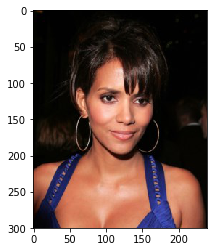

In [14]:
import random as rand
i = rand.randrange(0,len(clebs))
display_image(clebs.iloc[i]['Image'])